# Lecture 5 Companion Notebook: Group Convolution and Steerable Filters

This notebook accompanies **Lecture 5: Group Convolution and Steerable Filters**.

Goal: build an *executable intuition* for the statement:

- admissible kernels form a **linear subspace**
- choosing a basis makes equivariance **hold by construction**
- "rotate the filter" becomes "multiply coefficients by a small matrix"

We will use a concrete, tiny example: **steering derivative-of-Gaussian filters** in 2D.


## 0. Setup

We will use:

- `numpy` for arrays
- `scipy.ndimage` for rotating discrete filters
- `matplotlib` for visualization

No deep learning library is required for these demos.


In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy import ndimage

np.set_printoptions(precision=4, suppress=True)

def show_filters(filters, titles=None, cmap="viridis", vlim=None):
    """Display a row of 2D filters."""
    n = len(filters)
    fig, axes = plt.subplots(1, n, figsize=(3.2*n, 3.0))
    if n == 1:
        axes = [axes]
    for i, (ax, f) in enumerate(zip(axes, filters)):
        ax.set_xticks([]); ax.set_yticks([])
        if titles is not None:
            ax.set_title(titles[i])
        if vlim is None:
            im = ax.imshow(f, cmap=cmap)
        else:
            im = ax.imshow(f, cmap=cmap, vmin=-vlim, vmax=vlim)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()

def rotate_filter(f, theta_deg, order=1):
    """Rotate filter consistent with (g·x)(u)=x(g^{-1}u): use -theta."""
    return ndimage.rotate(f, -theta_deg, reshape=False, order=order, mode="constant", cval=0.0)

def l2_rel_error(a, b, eps=1e-12):
    return np.linalg.norm(a-b) / (np.linalg.norm(b) + eps)


## 1. A tiny steerable basis (first-order)

A classic steerable family is the **first derivatives of a Gaussian**:

- $\phi_1 = \partial_x G$
- $\phi_2 = \partial_y G$

In the *continuous* setting, rotating the filter by angle $\theta$ produces a linear combination:

- $R_\theta(\partial_x G) = \cos\theta\,\partial_x G + \sin\theta\,\partial_y G$
- $R_\theta(\partial_y G) = -\sin\theta\,\partial_x G + \cos\theta\,\partial_y G$

So the basis transforms by a $2\times 2$ rotation matrix.

On a discrete grid, this will only be approximate (because of sampling + interpolation),
but the effect is still very clear.


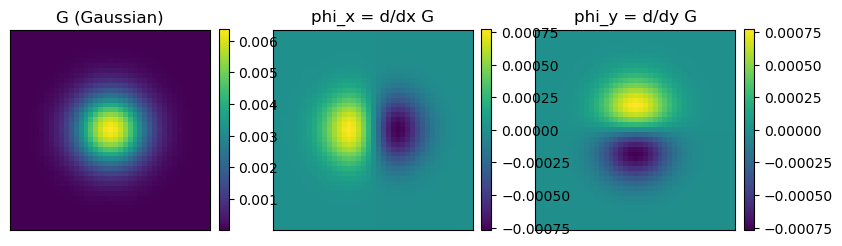

In [12]:
def gaussian_2d(size=31, sigma=4.0):
    assert size % 2 == 1, "use odd size so the filter is centered"
    r = size // 2
    xs = np.arange(-r, r+1)
    X, Y = np.meshgrid(xs, xs, indexing="xy")
    G = np.exp(-(X**2 + Y**2) / (2*sigma**2))
    G /= G.sum()
    return G, X, Y

def d_gaussian_filters(size=31, sigma=4.0):
    G, X, Y = gaussian_2d(size=size, sigma=sigma)
    # (unnormalized) derivatives of Gaussian; scale is irrelevant for steering demos
    Gx = -(X / (sigma**2)) * G
    Gy = -(Y / (sigma**2)) * G
    # zero-mean for display stability
    Gx -= Gx.mean()
    Gy -= Gy.mean()
    return G, Gx, Gy

G, phi_x, phi_y = d_gaussian_filters(size=41, sigma=5.0)
show_filters([G, phi_x, phi_y], titles=["G (Gaussian)", "phi_x = d/dx G", "phi_y = d/dy G"], vlim=None)


## 2. Steering by coefficient mixing

Pick a direction angle $\theta$ and define the *steered* filter

$k_\theta = \cos\theta\,\phi_x + \sin\theta\,\phi_y$.

Now compare:

1. `rotate_filter(phi_x, theta)`  (literally rotate the discretized filter)
2. `cos(theta)*phi_x + sin(theta)*phi_y` (mix basis filters)

In the continuous theory these are equal; on the grid they should be close.


theta = 35.0 deg, relative L2 error(rotated vs steered) = 6.9280e-04


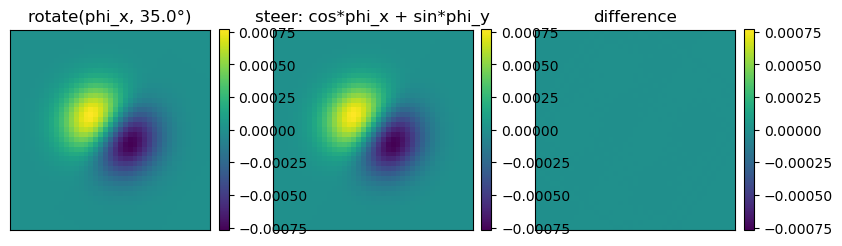

In [13]:
def steer_first_order(theta_deg, phi_x, phi_y):
    theta = math.radians(theta_deg)
    return math.cos(theta) * phi_x + math.sin(theta) * phi_y

theta_deg = 35.0
rotated = rotate_filter(phi_x, theta_deg, order=3)  # smoother interpolation
steered = steer_first_order(theta_deg, phi_x, phi_y)

err = l2_rel_error(rotated, steered)
print(f"theta = {theta_deg} deg, relative L2 error(rotated vs steered) = {err:.4e}")

show_filters([rotated, steered, rotated-steered],
             titles=[f"rotate(phi_x, {theta_deg}°)", f"steer: cos*phi_x + sin*phi_y", "difference"],
             vlim=np.max(np.abs(rotated)))


## 3. The representation $A(\theta)$ acting on coefficients

Any filter in the span can be written as

$k = a\,\phi_x + b\,\phi_y$.

If the basis is steerable, rotating the filter corresponds to updating the coefficient vector
$\alpha = (a,b)^\top$ by a small matrix:

$\alpha' = A(\theta)\,\alpha$,

where for first-order derivatives we expect

$A(\theta) = \begin{pmatrix}\cos\theta & -\sin\theta\\ \sin\theta & \cos\theta\end{pmatrix}$.

We'll verify this numerically by:

- choosing random $(a,b)$
- rotating the resulting filter
- fitting the best coefficients $(\hat a,\hat b)$ in the basis
- comparing $(\hat a,\hat b)$ to $A(\theta)(a,b)$


original alpha        = [ 0.1257 -0.1321]
predicted alpha'      = [0.1773 0.0428]
fitted alpha_hat      = [0.1773 0.0428]
coeff error (L2)      = 1.9784119934090858e-06
filter recon error    = 0.000690007961853055


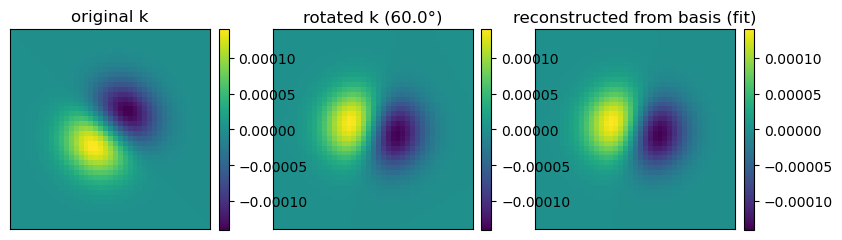

In [14]:
def fit_coeffs_in_basis(k, basis):
    """Least-squares fit of k as sum_i alpha_i basis_i."""
    B = np.stack([b.reshape(-1) for b in basis], axis=1)  # (N, m)
    y = k.reshape(-1)
    alpha_hat, *_ = np.linalg.lstsq(B, y, rcond=None)
    return alpha_hat

def A_first_order(theta_deg):
    t = math.radians(theta_deg)
    return np.array([[math.cos(t), -math.sin(t)],
                     [math.sin(t),  math.cos(t)]], dtype=float)

rng = np.random.default_rng(0)
a, b = rng.normal(size=2)
k = a*phi_x + b*phi_y

theta_deg = 60.0
k_rot = rotate_filter(k, theta_deg, order=3)

alpha_hat = fit_coeffs_in_basis(k_rot, [phi_x, phi_y])
alpha_pred = A_first_order(theta_deg) @ np.array([a, b])

print("original alpha        =", np.array([a,b]))
print("predicted alpha'      =", alpha_pred)
print("fitted alpha_hat      =", alpha_hat)
print("coeff error (L2)      =", np.linalg.norm(alpha_hat - alpha_pred))

k_fit = alpha_hat[0]*phi_x + alpha_hat[1]*phi_y
print("filter recon error    =", l2_rel_error(k_fit, k_rot))

show_filters([k, k_rot, k_fit],
             titles=["original k", f"rotated k ({theta_deg}°)", "reconstructed from basis (fit)"],
             vlim=np.max(np.abs(k_rot)))


## 4. Basis visualization + linear combinations (what learning does)

Steerable CNNs typically learn **coefficients** in an admissible subspace.

Here we visualize:

- the basis filters
- several random linear combinations

This is the "kernel subspace" picture: learning selects coordinates $\alpha$.


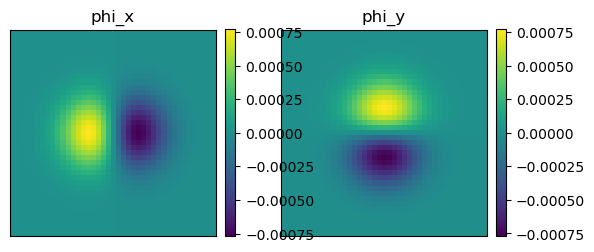

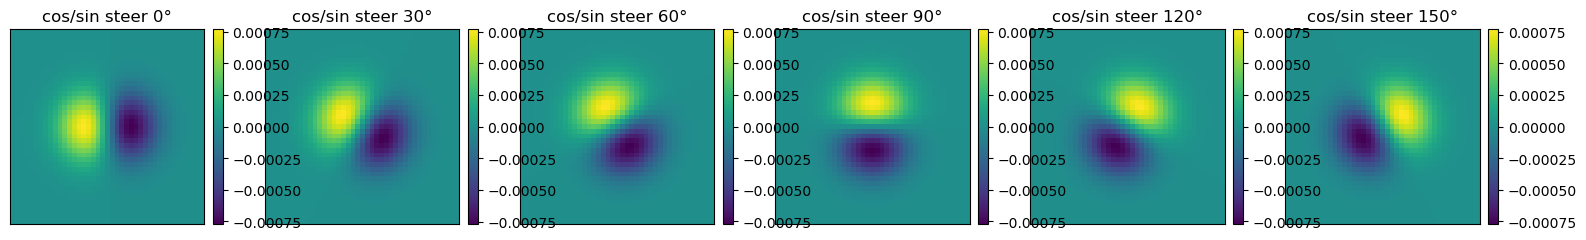

In [15]:
# Show the basis
show_filters([phi_x, phi_y], titles=["phi_x", "phi_y"], vlim=max(np.max(np.abs(phi_x)), np.max(np.abs(phi_y))))

# Show random combinations
thetas = [0, 30, 60, 90, 120, 150]
filters = [steer_first_order(t, phi_x, phi_y) for t in thetas]
titles = [f"cos/sin steer {t}°" for t in thetas]
show_filters(filters, titles=titles, vlim=np.max(np.abs(filters[0])))


## 5. Connection to Lecture 5 language

- The **admissible kernels** form a vector space $\mathcal{K}$ (a linear subspace).
- Choosing a basis $\{\phi_i\}$ means any kernel is $k = \sum_i \alpha_i \phi_i$.
- A group action on kernels induces a representation on coefficient space:
  $\alpha' = A(g)\alpha$.

In this notebook we saw that:

- for the first-order derivative-of-Gaussian basis, $A(\theta)$ is (approximately) a $2\times 2$ rotation matrix.
- rotating a filter in the span can be reproduced by mixing basis filters.


angles: [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]
mean coeff error: 8.676614122423717e-06
mean recon rel L2 error: 0.000499633478610543


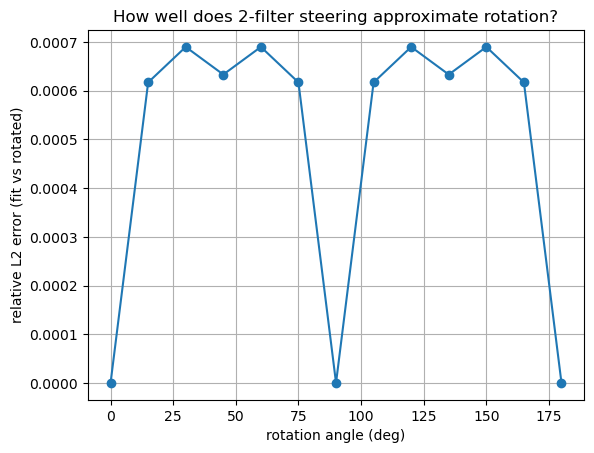

In [16]:
# A compact "sanity check" sweep over angles
a, b = 1.0, -0.3
k = a*phi_x + b*phi_y

angles = np.arange(0, 181, 15)
coeff_errs = []
recon_errs = []

for th in angles:
    k_rot = rotate_filter(k, th, order=3)
    alpha_hat = fit_coeffs_in_basis(k_rot, [phi_x, phi_y])
    alpha_pred = A_first_order(th) @ np.array([a, b])
    coeff_errs.append(np.linalg.norm(alpha_hat - alpha_pred))
    k_fit = alpha_hat[0]*phi_x + alpha_hat[1]*phi_y
    recon_errs.append(l2_rel_error(k_fit, k_rot))

print("angles:", angles.tolist())
print("mean coeff error:", float(np.mean(coeff_errs)))
print("mean recon rel L2 error:", float(np.mean(recon_errs)))

plt.figure()
plt.plot(angles, recon_errs, marker="o")
plt.xlabel("rotation angle (deg)")
plt.ylabel("relative L2 error (fit vs rotated)")
plt.title("How well does 2-filter steering approximate rotation?")
plt.grid(True)
plt.show()
